# pandas DataFrameと相対時間

pandasのDataFrameで相対時間を扱うことで以下のデータ整理を実施する｡

1. 各機種の発売を起点とした累計グラフ(週販データがあるもののみ)
2. 各機種の発売日を起点とした累計(年イチデータとの混在)
3. Switchの月ごとの販売量の年ごとの比較

## pandasの相対時間の扱いのネット上の調査

https://note.nkmk.me/python-datetime-timedelta-measure-time/


In [93]:
# timedeltaをindexにしたDataFrameは作れるのか

import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
from typing import Dict

hw_all = pd.read_pickle("clean/hw_all.pkl")
hw_cumsum = pd.read_pickle("clean/hw_cumsum.pkl")
hw_year = pd.read_pickle("clean/hw_year.pkl")

In [27]:
hw_switch = hw_cumsum['NSW'] # Switchの列だけ
hw_ps5 = hw_cumsum['PS5'] # PS5の列だけ

# dropnaでNaNがある行を落とす
hw_switch.dropna(inplace=True)
hw_ps5.dropna(inplace=True)

# concatで結合｡axisで横に繋げば NSWとPS5それぞれのデータ列が出来る
hw_aaa = pd.concat([hw_switch, hw_ps5], axis=1)

In [63]:
# DatetimeIndex型になっちゃうと振り直しは実質できない
# to_dictで変換して違うDataFrameを作ったほうがいい

<AxesSubplot:>

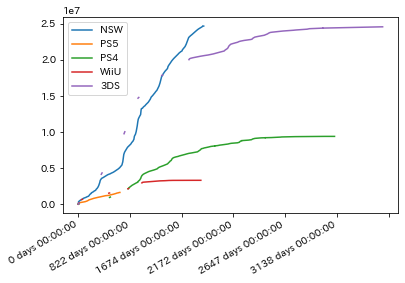

In [120]:
# launch_days -> {"NSW": datetime, "PS5": datetime}
#
def sum2launchsum(hw_sum:pd.DataFrame, launch_days:Dict) -> pd.DataFrame :
    new_dict = {}
    dzero = datetime.timedelta(0)
    for hw_key, epoch in launch_days.items():
        this_dict = {}
        for day,num in hw_sum[hw_key].to_dict().items():
            delta = day - epoch
            if (dzero <= delta):
                this_dict[delta] = num
        this_dict[dzero] = 0.0
        new_dict[hw_key] = this_dict
        
    return pd.DataFrame(new_dict).sort_index()

launch = {"NSW":datetime.datetime(2017, 3, 3),
          "PS5":datetime.datetime(2020, 11, 12),
          "PS4":datetime.datetime(2013, 11, 15),
          "WiiU": datetime.datetime(2012,11,18),
          "3DS":datetime.datetime(2011,2,26)}

# hw_year_sum = hw_year.cumsum()
# sp3 = sum2launchsum(hw_year_sum, launch)

sp3 = sum2launchsum(hw_cumsum, launch)

# interpolateはNaNを前後の値から補間する｡
sp3.interpolate(method="linear", limit=3).plot()

,NSW,PS5
3 days,330637.0,NaN
4 days,362347.0,118085.0
10 days,394057.0,139530.5
11 days,419467.5,160976.0
17 days,444878.0,181205.5
...,...,...
1858 days,24344293.0,1618145.0
1865 days,24405455.0,1618145.0
1872 days,24465744.0,1618145.0
1879 days,24523234.0,1618145.0


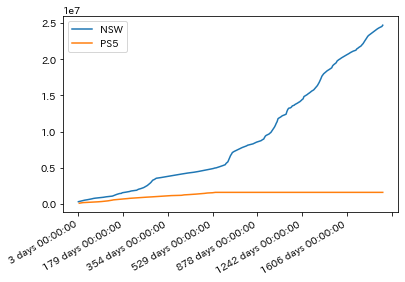

In [91]:
switch_dict = {}
epoch = datetime.datetime(2017, 3, 3, 0, 0, 0)
for k, v in hw_switch.to_dict().items():
    delta = k - epoch
    switch_dict[delta] = v
    
ps5_dict = {}
epoch = datetime.datetime(2020, 11, 12, 0, 0, 0)
for k, v in hw_ps5.to_dict().items():
    delta = k - epoch
    ps5_dict[delta] = v
    
ps5_dict

# 入力データを作り出す
s2 = pd.DataFrame({"NSW": switch_dict})
p2 = pd.DataFrame({"PS5": ps5_dict})

sp2 = pd.concat([s2, p2], axis=1).sort_index() # indexのソートは必要

# interpolateはNaNを前後の値から補間する｡
sp2.interpolate(method='linear').plot()
sp2.interpolate(method='linear')

<AxesSubplot:>

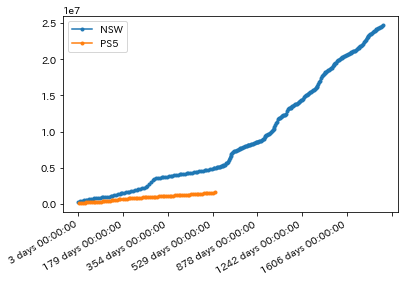

In [86]:
sp3.plot(marker='.')

In [50]:
# Indexオブジェクトはenumerateなのでloopで回せる
sw_index = hw_switch.index
delta_map = {}
epoch = datetime.datetime(2017, 3, 3, 0, 0, 0)
for i in sw_index:
    ii = pd.Timestamp(i).value
    delta_map[ii] = i - epoch

In [54]:
hw_s2 = hw_switch.index.astype(int)
hw_s2.reindex(index=delta_map)

TypeError: reindex() got an unexpected keyword argument 'index'

In [56]:
hw_s2.index

AttributeError: 'Int64Index' object has no attribute 'index'

In [ ]:
# renameかreindexを使うのか...